In [1]:
# in this notebook, we are testing out some new math to make the model a bit more self-consistent and logical
# and making sure it still runs to steady state in a reasonable time when those changes are made
# see notes from 3/8/23 in red, gridded notebook for details on changes
# and/or compare to "default.ipynb"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
zeta = 0.001 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, zeta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 35
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-zeta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * zeta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, zeta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

175000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

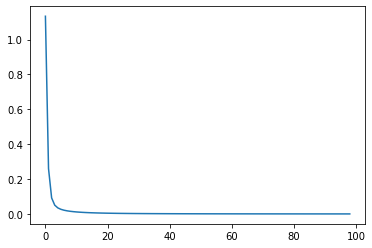

In [8]:
plt.plot(S)

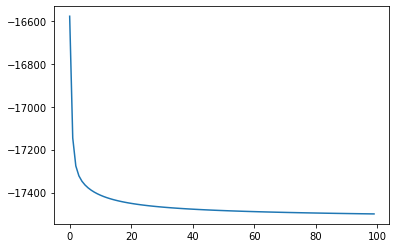

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0003729094519512728

In [11]:
eta

array([-16578.81231077, -17145.87243642, -17275.96120423, -17322.02925055,
       -17347.30512901, -17364.74348751, -17378.08990592, -17388.87587019,
       -17397.88251385, -17405.56920352, -17412.23331976, -17418.08078981,
       -17423.26133025, -17427.88780553, -17432.04768375, -17435.81023313,
       -17439.23126701, -17442.35639933, -17445.2233524 , -17447.86363797,
       -17450.30381003, -17452.56641655, -17454.67073437, -17456.6333448 ,
       -17458.46858986, -17460.18893785, -17461.80527903, -17463.32716674,
       -17464.76301554, -17466.12026517, -17467.40551701, -17468.62464833,
       -17469.78290843, -17470.88499996, -17471.93514797, -17472.93715889,
       -17473.89447095, -17474.81019757, -17475.68716484, -17476.52794388,
       -17477.33487901, -17478.11011226, -17478.85560481, -17479.57315571,
       -17480.26441842, -17480.93091533, -17481.57405053, -17482.19512121,
       -17482.79532773, -17483.37578255, -17483.9375182 , -17484.48149444,
       -17485.00860461, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([9.20587690e+02, 3.53527565e+02, 2.23438797e+02, 1.77370750e+02,
       1.52094872e+02, 1.34656513e+02, 1.21310095e+02, 1.10524131e+02,
       1.01517487e+02, 9.38307975e+01, 8.71666812e+01, 8.13192112e+01,
       7.61386707e+01, 7.15121955e+01, 6.73523172e+01, 6.35897679e+01,
       6.01687340e+01, 5.70436017e+01, 5.41766486e+01, 5.15363630e+01,
       4.90961909e+01, 4.68335844e+01, 4.47292666e+01, 4.27666562e+01,
       4.09314111e+01, 3.92110631e+01, 3.75947219e+01, 3.60728342e+01,
       3.46369854e+01, 3.32797358e+01, 3.19944840e+01, 3.07753526e+01,
       2.96170926e+01, 2.85150010e+01, 2.74648530e+01, 2.64628421e+01,
       2.55055300e+01, 2.45898034e+01, 2.37128361e+01, 2.28720571e+01,
       2.20651220e+01, 2.12898887e+01, 2.05443962e+01, 1.98268453e+01,
       1.91355826e+01, 1.84690857e+01, 1.78259505e+01, 1.72048798e+01,
       1.66046733e+01, 1.60242184e+01, 1.54624828e+01, 1.49185065e+01,
       1.43913964e+01, 1.38803196e+01, 1.33844993e+01, 1.29032091e+01,
      

In [14]:
ql

array([0.01535183, 0.02834687, 0.03934693, 0.04865829, 0.05654018,
       0.06321206, 0.06885968, 0.07364029, 0.07768698, 0.08111244,
       0.08401203, 0.08646647, 0.08854412, 0.0903028 , 0.0917915 ,
       0.09305165, 0.09411835, 0.09502129, 0.09578562, 0.0964326 ,
       0.09698026, 0.09744385, 0.09783626, 0.09816844, 0.09844961,
       0.09868763, 0.0988891 , 0.09905964, 0.09920401, 0.09932621,
       0.09942965, 0.0995172 , 0.09959132, 0.09965406, 0.09970717,
       0.09975212, 0.09979018, 0.09982239, 0.09984966, 0.09987274,
       0.09989227, 0.09990881, 0.09992281, 0.09993466, 0.09994469,
       0.09995318, 0.09996037, 0.09996645, 0.0999716 , 0.09997596,
       0.09997965, 0.09998278, 0.09998542, 0.09998766, 0.09998955,
       0.09999116, 0.09999251, 0.09999366, 0.09999464, 0.09999546,
       0.09999616, 0.09999675, 0.09999725, 0.09999767, 0.09999803,
       0.09999833, 0.09999859, 0.0999988 , 0.09999899, 0.09999914,
       0.09999927, 0.09999939, 0.09999948, 0.09999956, 0.09999

In [15]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

In [16]:
ql/B_valley

array([0.00020353, 0.00030168, 0.00037808, 0.00043713, 0.00048304,
       0.00051879, 0.00054657, 0.00056803, 0.00058443, 0.00059677,
       0.00060586, 0.00061231, 0.00061666, 0.0006193 , 0.00062058,
       0.00062076, 0.00062007, 0.0006187 , 0.00061678, 0.00061444,
       0.00061178, 0.00060888, 0.0006058 , 0.00060259, 0.0005993 ,
       0.00059596, 0.0005926 , 0.00058925, 0.0005859 , 0.00058259,
       0.00057932, 0.00057611, 0.00057294, 0.00056984, 0.0005668 ,
       0.00056382, 0.00056091, 0.00055807, 0.00055529, 0.00055258,
       0.00054993, 0.00054734, 0.00054482, 0.00054236, 0.00053995,
       0.0005376 , 0.00053531, 0.00053307, 0.00053088, 0.00052874,
       0.00052665, 0.0005246 , 0.0005226 , 0.00052064, 0.00051873,
       0.00051686, 0.00051502, 0.00051322, 0.00051146, 0.00050973,
       0.00050804, 0.00050638, 0.00050475, 0.00050315, 0.00050159,
       0.00050005, 0.00049853, 0.00049705, 0.00049559, 0.00049416,
       0.00049275, 0.00049136, 0.00049   , 0.00048866, 0.00048

In [17]:
# calc width

b = (kb * Q[1:] * S**(7/6)) / (D**(3/2))

In [18]:
# save csv files

np.savetxt('elevation csv files/eta_default_softsed.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_default_softsed.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_default_softsed.csv', S, delimiter = ',')
np.savetxt('width csv files/b_default_softsed.csv', b, delimiter = ',')
np.savetxt('Qs csv files/Qs_default_softsed.csv', Qs, delimiter = ',')